- competition/dataset : [https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/overview](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/overview)
- date : 2021/02/11
- original : [https://www.kaggle.com/wvadim/keras-tf-lb-0-18](https://www.kaggle.com/wvadim/keras-tf-lb-0-18)

## Keras+TF LB 0.18

**✏ 필사 1회** 

### 1. Introduction
**Introduction** 노트북을 읽기 전에 이 노트북이 이미 있는 노트북들의 모음이며 모델 수정은 다음 노트북들을 참고했음을 알립니다:  
* 데이터 분석: [https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python](https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python)  
* 이미지 컨버젼, 네트워크 구조: [https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d](https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d)  
* 기타 아이디어: [https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl](https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl)  
* MadScientist의 커널 또한 참고했으나 링크를 못 찾았습니다.  

이 커널의 모델을 실행해보기 전 위에 안내된 커널들을 먼저 실행해보는 것도 좋은 생각입니다.  

**Comments** 이 코드는 1080ti에서 실행했으며 저사양 GPU나 CPU를 사용할 경우 매우 느릴 것입니다.  

모델 학습 후 kears가 메모리를 확보하지 못하기 때문에 여기서 훈련결과는 불완전할 수 있으므로 노트북에서는 GPU 실행방법을 몰라도 된다고 생각합니다.  

또한 random seed 초기화에 대해 잘 모르겠고, 확인하지 않았으므로 결과가 조금씩 달라질 수 있습니다.  

In [28]:
# Random initialization
import numpy as np
np.random.seed(12345)
import tensorflow as tf
tf.random.set_seed(123)

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle,
                                 denoise_bilateral,
                                 denoise_wavelet,
                                 estimate_sigma,
                                 denoise_tv_bregman,
                                 denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,
                          GlobalAveragePooling2D, Lambda, GlobalMaxPooling2D)
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

먼저, 약간의 데이터 전처리가 필요합니다.  

기본적인 아이디어는 데이터셋에 주어진 이미지는 노이즈가 많아서 이러한 노이즈들을 제거한다면 자체에서 더 잘 예측할 수 있고 노이즈가 있는 데이터셋을 구축할 수 있습니다.  

모델 학습에 사용하게 될 전역 변수들을 추출하기 위해 데이터셋에 노이즈를 없애는 자동 인코더를 훈련하는 것도 흥미롭습니다.

In [29]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [30]:
def denoise(x, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in x])

In [31]:
def smooth(x, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in x])

In [32]:
def grayscale(x):
    return np.asarray([rgb2gray(item) for item in x])

In [33]:
train = pd.read_json('data/train.json')
train['inc_angle'] = train['inc_angle'].replace('na', 0)
train['inc_angle'] = train['inc_angle'].astype(float).fillna(0.0)

# 모델의 효율을 높이고 적절한 파라미터를 선택하기 위한 플래그
train_all = True
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [34]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    
    # 벡터 -> 사진 포맷
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    
    if train_b and clean_b:
        # 데이터 평활화 및 노이즈 제거
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    
    if labeled:
        y = np.array(frame['is_iceberg'])
    else:
        y = None
    
    return y, band, images

In [35]:
y_train, x_b, x_images = create_dataset(train, True)

Denoising and reshaping
RGB done


랜덤 이미지들을 시각화하여 정제가 얼마나 진행되었는지 확인할 수 있습니다.

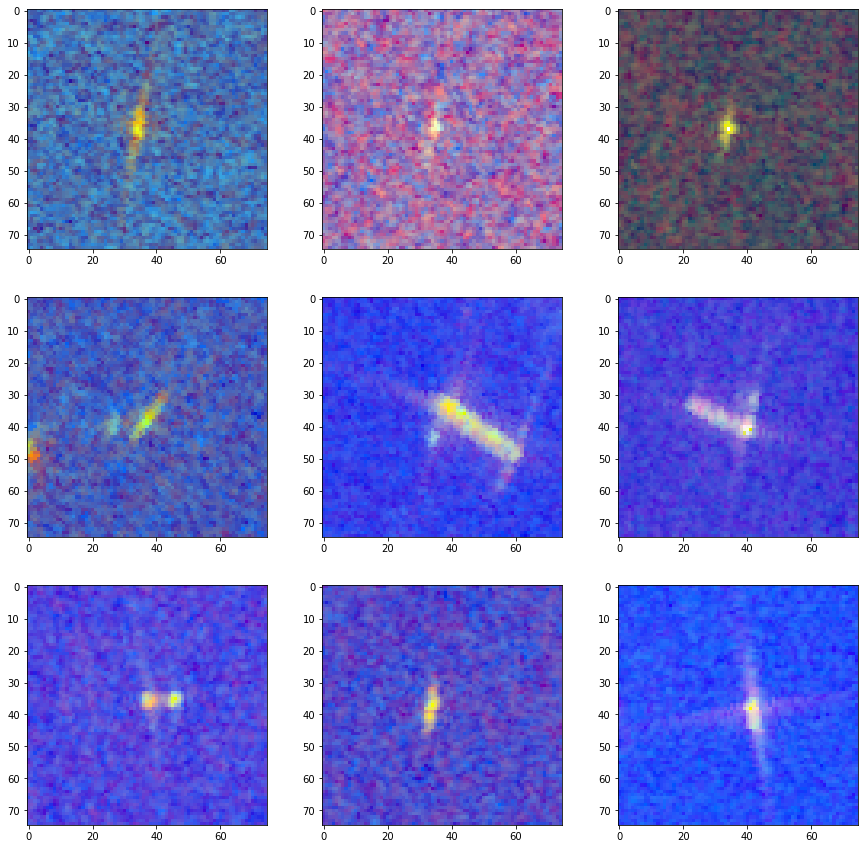

In [36]:
fig = plt.figure(200, figsize=(15, 15))
random_indices = np.random.choice(range(len(x_images)), 9, False)
subset = x_images[random_indices]
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

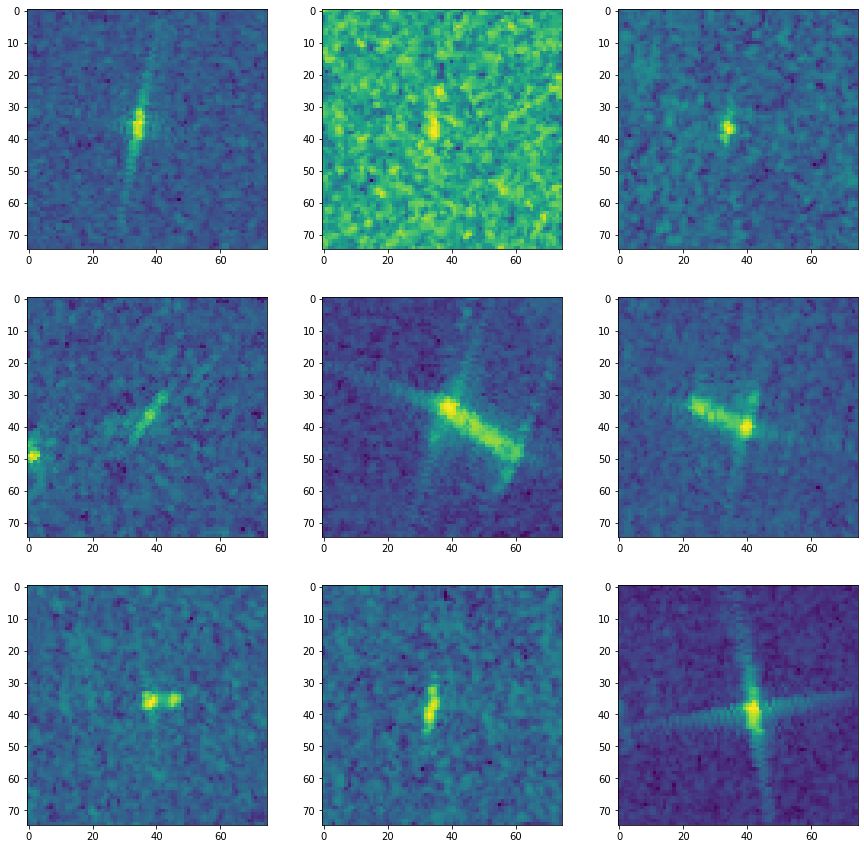

In [37]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indices]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

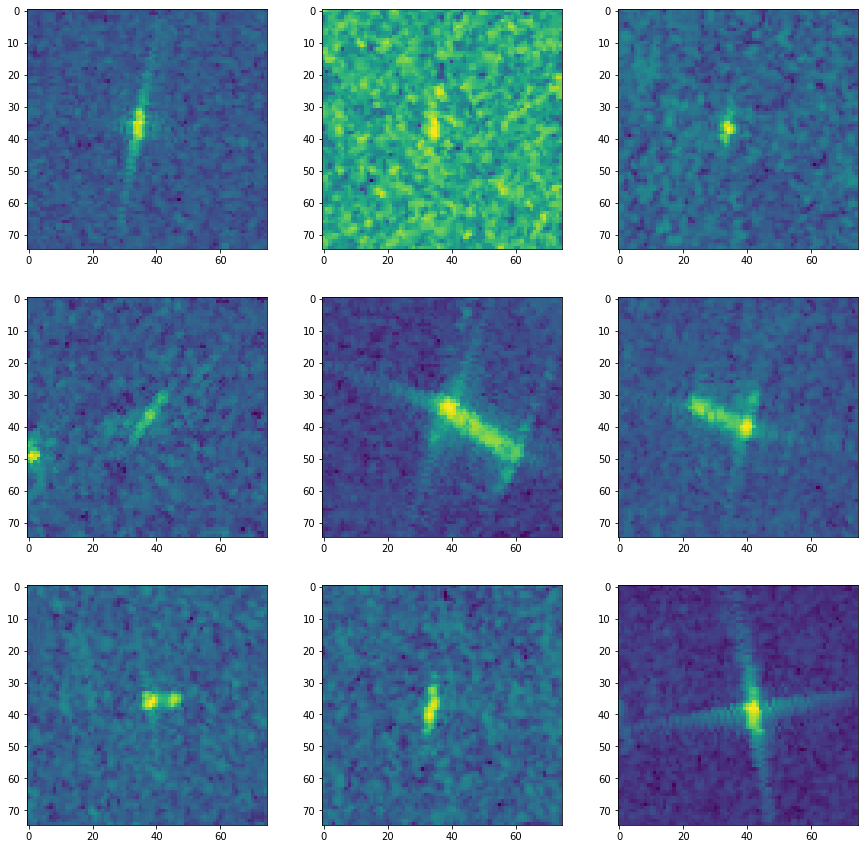

In [38]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indices]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

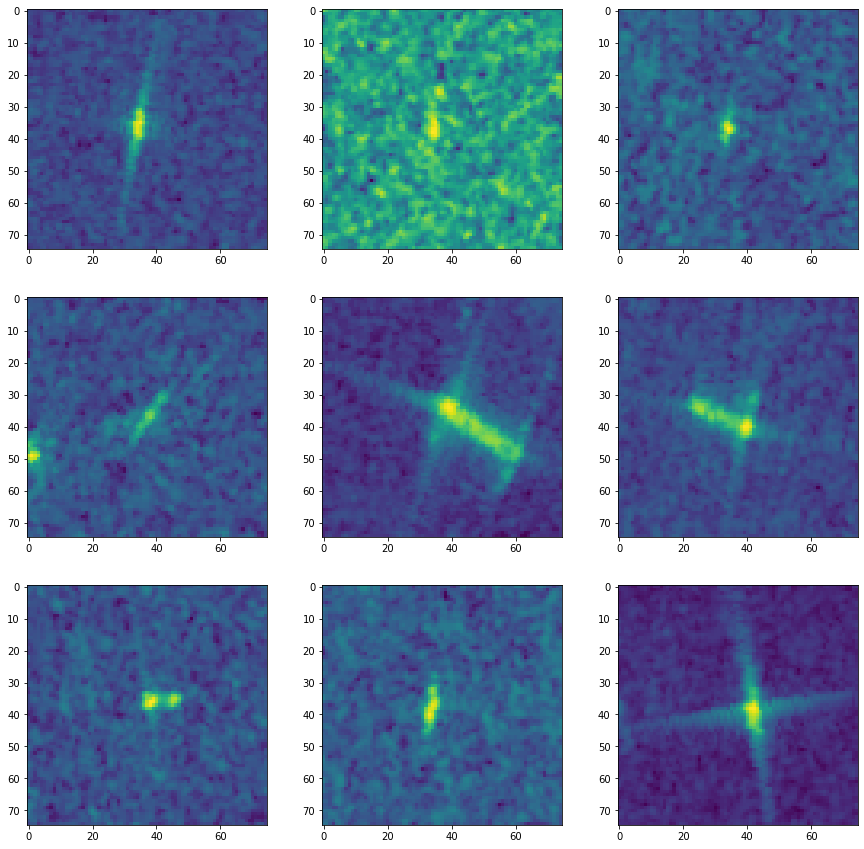

In [39]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indices]
subset = smooth(denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
plt.show()

**A few words about model** 모델 자체는 3개의 다층 신경 네트워크로 구성되어 있습니다. 두 개의 기본 네트워크와 하나가 결합되어 있습니다. 한 가지 아이디어는 별개의 데이터 표현에 대해 두 개의 기본 네트워크를 학습하고, 공통 네트워크 훈련을 위해 훈련된 컨볼루션 레이어를 조합하여 사용하는 것입니다.  

이러한 네트워크 구조는 도입부에 언급했던 노트북을 참고했습니다.  

트레이닝을 위해 3개의 데이터셋을 사용했으며, 하나의 네트워크는 한 데이터만 보고 기본적으로 모델 선택을 위해 keras val split을 사용합니다.

In [40]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [41]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [42]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [43]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [44]:
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [45]:
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [46]:
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [48]:
# 최적의 파라미터
# epochs: 250
# learning rate: 8e-5
# batch size: 32
common_model = train_models((y_train, x_b, x_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network


C:\Users\PC\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
38/38 [==============================] - 11s 207ms/step - loss: 0.7101 - accuracy: 0.5473 - val_loss: 1.0922 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 2/50
38/38 [==============================] - 7s 174ms/step - loss: 0.6215 - accuracy: 0.6258 - val_loss: 1.1568 - val_accuracy: 0.5253
Epoch 3/50
38/38 [==============================] - 6s 165ms/step - loss: 0.6162 - accuracy: 0.6433 - val_loss: 0.7153 - val_accuracy: 0.5253
INFO:tensorflow:Assets written to: model_b\assets
Epoch 4/50
38/38 [==============================] - 6s 164ms/step - loss: 0.5838 - accuracy: 0.6536 - val_loss: 0.6891 - val_accuracy: 0.5714
INFO:tensorflow:Assets written to: model_b\assets
Epoch 5/50
38/38 [==============================] - 6s 165ms/step - loss: 0.5895 - accuracy: 0.6888 - val_loss: 0.6992 - val_accuracy: 0.5069
Epoch 6/50
38/38 [==============================] - 6s 164ms/step - loss: 0.5024 - accuracy: 0.7344 - val_loss: 0.7953 - val_accuracy: 0.51

OpError: 

In [ ]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json('data/test.json')
    y_fin, x_fin_b, x_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([x_fin_b, x_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id':test['id'], 'is_iceberg':prediction.reshape((prediction.shape[0]))})
    submission.to_csv('data/subsmission_4_subsmission.csv', index=False)
    print('Done')